In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

c_in = 1/1000
z = 1
alpha = 0.5
T = 298
E_eq = 0.0
##E = [0.1,0.2,0.3]
E = np.arange(0,0.3,0.05)
n = 2

## reference C*_oxidation and C*_reduction
Co = 1
Cr = 1

a_v = 4e10
L = 10e-6
x = np.arange(0, L+0.5e-6, 0.5e-6)
i_0 = 2e-4
F = 96485
D = 0.77e-5
RT = 0.08206*T

def beta(i):
    return alpha*z*F/(8.314*298)*(E[i]-E_eq)

## reaction, called by c_cl
def y(i):
    return (a_v*i_0/(n*F*D) * np.exp(alpha*z*F/(8.314*298)*(E[i]-E_eq)))

## concentration with rxn plugged in
def c_cl(i):
    g = np.sqrt(y(i))
    b = beta(i)
    ret = []
    for z in x:
        a = 1.1*np.exp(-2*b) + ((c_in*RT-(1.1*np.exp(-2*b)))/(np.exp(-2*L*g)+1))*(np.exp(g*(z-2*L))+np.exp(-g*z))
        ret = np.append(ret,a)
    return ret
    
def current(i):
    E = np.arange(-0.3,0.3,0.05)
    g = np.sqrt(y(i))
    b = beta(i)
    ret = []
    z = 0;
    dcdx = g*((c_in*RT-(1.1*np.exp(-2*b)))/(np.exp(-2*L*g)+1))*(np.exp(g*(z-2*L))-np.exp(-g*z))
    ## flux in here = 2*j_e from Yoon ?
    j_in = -D*dcdx
    
    return n*F*j_in



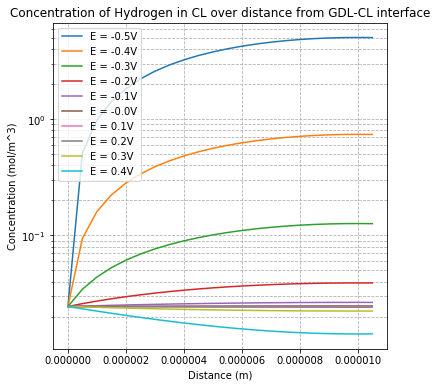

In [2]:
from scipy.integrate import trapz, simps

plt.figure(figsize=(6,6))
E = np.arange(-0.5,0.5,0.1)
for i in range(len(E)):
    plt.plot(x, c_cl(i), label='E = ' + str(round(E[i],2)) + 'V')

plt.title('Concentration of Hydrogen in CL over distance from GDL-CL interface')
plt.ylabel('Concentration (mol/m^3)')
plt.xlabel('Distance (m)')
plt.yscale('log')
plt.grid(True,which="both", linestyle='--')
plt.legend()
plt.show()

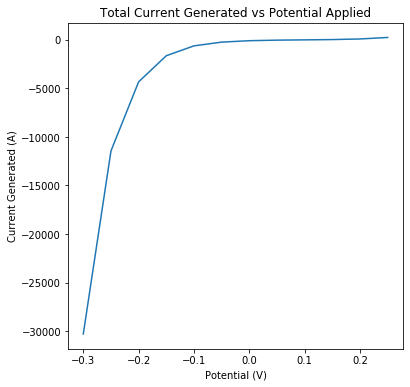

In [3]:
from scipy.integrate import trapz, simps

plt.figure(figsize=(6,6))
I = []
E = np.arange(-0.3,0.3,0.05)

for i in range(len(E)):
    ## area = trapz(c_cl(i), dx=0.5e-5)
    I = np.append(I,current(i))
    
plt.plot(E, I)

plt.title('Total Current Generated vs Potential Applied')
plt.ylabel('Current Generated (A)')
plt.xlabel('Potential (V)')
##plt.yscale('log')
##plt.grid(True,which="both", linestyle='--')
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

C_bulk = 0.01*1
##c_in = 1/1000
c_in = C_bulk
alpha = 0.5
E_eq = 0.0
n = 2
z = 1

## reference C*_oxidation and C*_reduction
Co = 1
Cr = 1

a_v = 4e10
L = R_a+del_film
x = np.arange(0, L+0.1*L, 0.05*L)
i_0 = 2e-4
F = 96485
D = 0.77e-5
RT = 0.08206*298

## yoon 2011
R_a = 0.1e-6
De = 8.45e-9
D_film = 2*De
del_film = 20e-9
phi = 0.3
##j_h2 = [-50,-200,-750,-1200,-2000]
r_i = np.arange(0, R_a+0.05e-7, 0.05e-7)
r_o = np.arange(R_a, R_a+del_film+0.05*del_film, 0.05*del_film)
i_0 = 2e-4
E = [0.3]
phi = 0
L_ca = 0.2
A_ca = 40
l_cl = 15e-6

## concentration with rxn plugged in
def c_cl(zed,i):
    g = np.sqrt(a_v*i_0/(n*F*D) * np.exp(alpha*z*F/(8.314*298)*(E[i]-E_eq)))
    b = alpha*z*F/(8.314*298)*(E[i]-E_eq)
    ret = []
    for zz in zed:
        a = 1.1*np.exp(-2*b) + ((c_in*RT-(1.1*np.exp(-2*b)))/(np.exp(-2*L*g)+1))*(np.exp(g*(zz-2*L))+np.exp(-g*zz))
        ret = np.append(ret,a)
    return ret

## butler volmer adjustments
def c_agg(zed,i):
    j_i = j_h2(zed,i)
    return -1/6*(zed**2)*j_i/De*((R_a+del_film)**2) + phi*c_film(zed,i) + 1/6*j_i/De*(R_a**2)
    
def c_film(zed,i):
    j_o = j_h2(zed,i)
    return 1/3*j_o*R_a**2/D_film*(1/zed-1)+C_bulk

def j_h2(zed,i):
    return i_0*c_cl(zed,i)/Cr*np.exp(a_v*z*F/RT*(E[i]-E_eq))*L_ca*A_ca/l_cl/(1-phi)

plt.figure(figsize=(6,6))
##different zed ranges
zed_i = []
zed_o = []
for i in range(len(r_i)):
    a = r_i[i]/(R_a+del_film)
    zed_i = np.append(zed_i,a)
for i in range(len(r_o)):
    a = r_o[i]/(R_a+del_film)
    zed_o = np.append(zed_o,a)

zed_i = np.array(zed_i)
zed_o = np.array(zed_o)
j = 0
plt.plot(zed_i, c_agg(zed_i,j), label='Agglomerate')
plt.plot(zed_o, c_film(zed_o,j), label='Film')

plt.title('Concentration of hydrogen across agglomerate-film length scale')
plt.yscale('log')
plt.ylabel('Concentration (mol/m^3)')
plt.xlabel('zed (r/(R_a+del_film))')
##plt.yscale('log')
##plt.grid(True,which="both", linestyle='--')
plt.legend()
plt.show()

NameError: name 'R_a' is not defined